# Bounding Box Detectors for TensorFlow

Let's walk through how we can detect objects from images and draw bounding boxes around each object.

# OpenCV

We'll use [OpenCV (computer vision)](https://opencv.org/) to draw some shapes over our image.

In [1]:
import numpy as np
import cv2  # OpenCV
import matplotlib.pyplot as plt

%matplotlib inline

# Define our image size

We'll use 3 channels (red, green, blue) to get color images.

In [2]:
HEIGHT=256
WIDTH=256
CHANNELS=3

# Draw an image with no objects

This will just be a black image of height HEIGHT and width WIDTH.

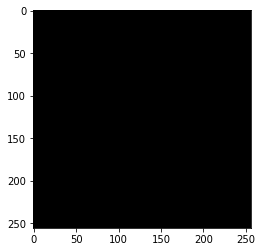

In [3]:
blank_image = np.zeros(shape = (HEIGHT,WIDTH,CHANNELS))

plt.imshow(blank_image);

# Draw rectangles

Note: This will be useful when we want to draw bounding boxes too!

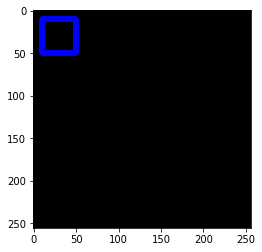

In [4]:
# Draw a rectangle on the blank image
cv2.rectangle(
              blank_image,
              pt1 = (10,10), pt2 = (50,50),
              color = (0,0,255),
              thickness = 5
            )

plt.imshow(blank_image / 255.);

# Draw circles

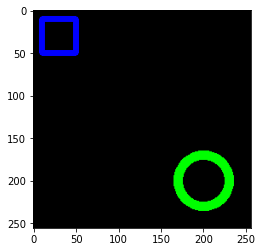

In [5]:
cv2.circle(
              blank_image,
              center = (200,200),
              radius = 30,
              color = (0,255,0),
              thickness = 10
            )

plt.imshow(blank_image / 255.);

# Draw Triangles

Or any polygon by just defining more points.

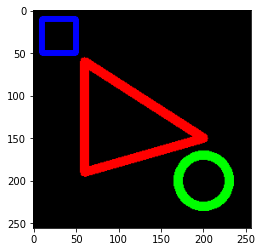

In [6]:
# Each point is a corner of the triangle
# If you add more points, you can get more complex polygons.
pts = [(60, 60), (60, 190), (200, 150)]

cv2.polylines(blank_image, np.array([pts]), True, color=(255, 0, 0), thickness=10)

plt.imshow(blank_image / 255.0);

# Let's write some methods to draw our shapes

This way we can reuse them later for our dataset.

In [7]:
def create_blank(height: int=HEIGHT, width: int=WIDTH, channels: int=CHANNELS) -> np.ndarray:
    """Create an empty image (all black)
    
    Args:
        height (int): Image height
        width (int): Image width
        channels (int): Image channels (usually 3 for RGB)
    """

    # Return an empty image
    return np.zeros(shape=(height, width, channels))

In [8]:
def create_shape(img: np.ndarray, shape_type: str) -> np.ndarray:
    """Create circle, rectangle, or triangle

    Overlays the shape onto the image img

    Args:
        img(np.ndarray): The original image
        shape_type(str): A string "rectangle", "circle", or "triangle"

    Returns:
        An image with the shape(s) overlaid on the original input image

    """

    thickness = np.random.randint(2, 10)

    BLUE = (0, 0, 255)
    GREEN = (0, 255, 0)
    RED = (255, 0, 0)

    if shape_type == "rectangle":

        max_width = 60
        left = np.random.randint(img.shape[0] - max_width)
        width = np.random.randint(20, max_width)
        right = left + width

        max_height = 60
        bottom = np.random.randint(img.shape[1] - max_height)
        height = np.random.randint(20, max_height)
        top = bottom + height

        cv2.rectangle(
            img, pt1=(left, bottom), pt2=(right, top), color=BLUE, thickness=thickness
        )

    elif shape_type == "circle":

        center_x = np.random.randint(img.shape[0] // 2 - 30, img.shape[0] // 2 + 30)
        center_y = np.random.randint(img.shape[1] // 2 - 30, img.shape[1] // 2 + 30)
        radius = np.random.randint(20, img.shape[1] // 3)

        cv2.circle(
            img,
            center=(center_x, center_y),
            radius=radius,
            color=GREEN,
            thickness=thickness,
        )

    elif shape_type == "triangle":

        # Each point is in a different quadrant
        pt1 = (
            np.random.randint(thickness + 1, img.shape[0] // 2),
            np.random.randint(thickness + 1, img.shape[1] // 2),
        )
        pt2 = (
            np.random.randint(
                img.shape[0] // 2 + thickness + 1, img.shape[0] - (thickness + 1)
            ),
            np.random.randint(
                img.shape[1] // 2 + thickness + 1, img.shape[1] - (thickness + 1)
            ),
        )

        pt3 = (
            np.random.randint(
                img.shape[0] // 2 + thickness + 1, img.shape[0] - (thickness + 1)
            ),
            np.random.randint(thickness + 1, img.shape[1] // 2 - thickness + 1),
        )

        pts = [pt1, pt2, pt3]

        cv2.polylines(img, np.array([pts]), True, RED, thickness=thickness)

    else:
        # Shape is unknown
        raise ValueError

    return img / 255.0

In [9]:
def random_shapes(shapes:list[str]) -> np.ndarray:
    """Create an image with random_shapes
    
    Args:
        A list of strings containing shape names to add to the image.
        
    Returns:
        An image with the specified shapes.
    """
    
    img = create_blank()
    
    for shape in shapes:
        
        create_shape(img, shape) 
        
    return img / img.max()
        

# create_shape

Creates a blank image with this shape

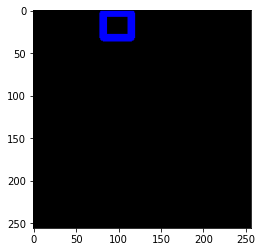

In [10]:
plt.imshow(create_shape(create_blank(), "rectangle"));

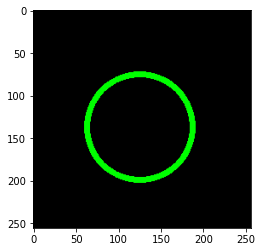

In [11]:
plt.imshow(create_shape(create_blank(), "circle"));

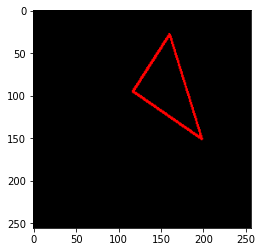

In [12]:
plt.imshow(create_shape(create_blank(), "triangle"));

# random_shapes

Create an image with a list of random shapes.

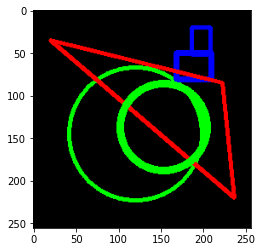

In [13]:
plt.imshow(random_shapes(["circle", "rectangle", "rectangle", "triangle", "circle"]));

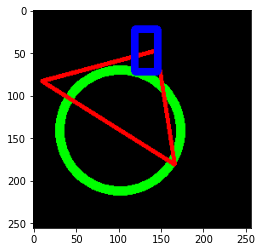

In [14]:
plt.imshow(random_shapes(["circle", "triangle", "rectangle"]));

# Creating the TensorFlow data loader

Dataloaders are essential. We need to create them because typically our entire dataset will *not* fit into RAM. A dataloader allows us to load (and augment) data at the time it is needed for the time it is needed.

In [15]:
import tensorflow as tf

## Our 3 classes

In [16]:
class_names = ["circle", "triangle", "rectangle"]

## Define a Python function that can be used in tf.data

We just use the same `random_shapes` Python function that we defined previously. So we are calling OpenCV from Python within TensorFlow. If we need to do any random flips/rotations/crops, then we can do so here as well.

In [17]:
def tf_shapes(n):
    """Return a random shape for the tf.data dataloader

    Args:
        n(int): 0=circle, 1=rectangle, 2=triangle

    Output:
        Image with shape, shape index
    """

    img = random_shapes(list([class_names[n]]))
    
    return img, n

## Define a random array of [0, 1, 2] that is n_data in length

In [18]:
n_data = 10000

random_ints = np.random.randint(0, high=len(class_names), size=[n_data,], dtype=np.int32)

## We can use `map` to change the random numbers into images

In [19]:
ds = tf.data.Dataset.from_tensor_slices(random_ints)

ds = ds.map(lambda x: tf.py_function(tf_shapes, [x], [tf.float32, tf.int32]))

# Test the TensorFlow dataloader
 
Let's print out a few random images

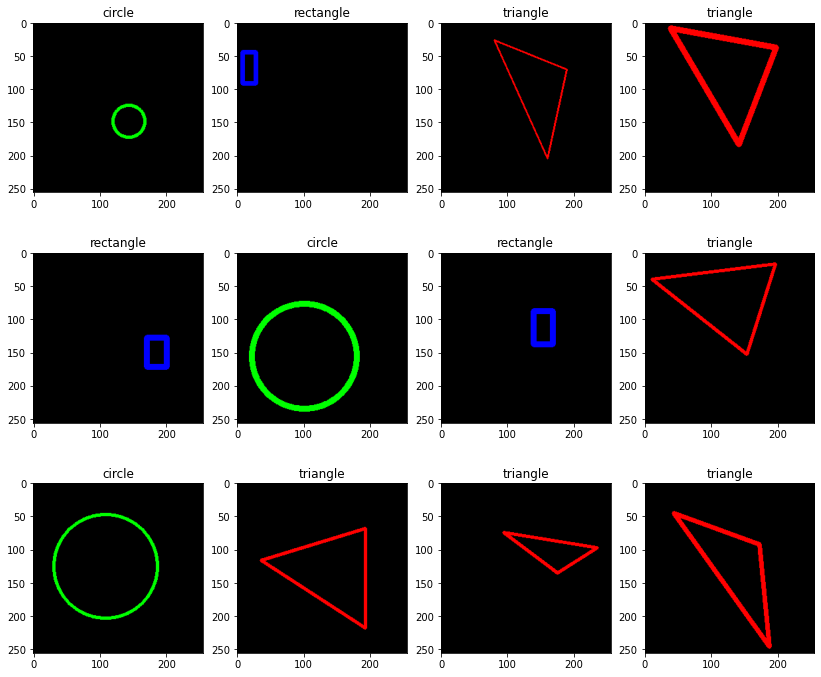

In [23]:
rows = 3
cols = 4

plt.figure(figsize=(14,12))

for idx, data in enumerate(ds.take(rows*cols)):
    
    img, class_num  = data[0], data[1]
    plt.subplot(rows,cols,idx+1)
    plt.imshow(img)
    plt.title(class_names[class_num])